# 01 - Classificando patologias em toras usando combinação de `LBP + SVM`

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from zipfile import ZipFile
from skimage import io
from skimage.filters import threshold_otsu
from skimage.feature import local_binary_pattern

# Parâmetros do LBP
METHOD = 'nri_uniform'
RADIUS = 1
N_POINTS = 8

TARGET_NAMES = {'normal': 0,
                'broca':1,
                'fissura': 2,
                'musgo': 3}

## Processando imagens

In [2]:
path_dict = {name: [] for name in TARGET_NAMES}

with ZipFile('./patologias_toras.zip') as zip_file:
  for path in zip_file.namelist():
    # a pasta de cada amostra é o segundo elemento do split
    folder = path.split('/')[1]
    # Separando amostras por classe
    if folder in TARGET_NAMES:
      path_dict[folder].append(f'./patologias_toras.zip/{path}')


# Mostrando quantidade de amostras por classe
qtd_amostras_p_classe = []
for target in path_dict:
  n_amostras = len(path_dict[target])
  print(f'{target}: {n_amostras} amostras')

  qtd_amostras_p_classe.append(n_amostras)

N_MIN_DE_AMOSTRAS = min(qtd_amostras_p_classe)
amostra = []

for target_name in TARGET_NAMES:
  path_list = path_dict[target_name]
  path_list_slice = path_list[:N_MIN_DE_AMOSTRAS]
  
  for path in path_list_slice:
    img = io.imread(path, as_gray=True)
    
    lbp = local_binary_pattern(image=img, P=N_POINTS, R=RADIUS, method=METHOD).flatten()
    
    hist = pd.Series(lbp).value_counts().sort_index()
    arr = np.zeros(59)
    for i in hist.index:
      arr[int(i)] = hist[i]

    df = pd.DataFrame(data=[arr])
    df['target'] = TARGET_NAMES[target_name]
    amostra.append(df)

data = pd.concat(amostra, ignore_index=True)
data.to_csv('./csvs/lbp_toras.csv')
data

normal: 107 amostras
broca: 90 amostras
fissura: 109 amostras
musgo: 111 amostras


,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,target
0,17737.0,5885.0,726.0,4301.0,916.0,6137.0,816.0,4633.0,907.0,2591.0,...,4011.0,1400.0,5076.0,1184.0,3869.0,1428.0,5201.0,21203.0,35941.0,0
1,18181.0,6080.0,840.0,4380.0,831.0,6234.0,814.0,4540.0,733.0,2045.0,...,3776.0,1145.0,5133.0,1249.0,3626.0,1091.0,5214.0,19367.0,34279.0,0
2,16913.0,6958.0,711.0,3244.0,860.0,7252.0,735.0,3315.0,831.0,2365.0,...,2957.0,1423.0,5950.0,1181.0,2696.0,1329.0,6002.0,19651.0,34041.0,0
3,20334.0,7594.0,937.0,4483.0,1066.0,7806.0,912.0,4693.0,915.0,2597.0,...,4046.0,1436.0,6926.0,1355.0,4068.0,1367.0,6752.0,23403.0,40270.0,0
4,20264.0,7912.0,869.0,4683.0,1005.0,8048.0,891.0,4605.0,930.0,2507.0,...,4031.0,1245.0,6977.0,1155.0,4177.0,1289.0,6944.0,22119.0,39074.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,996.0,432.0,43.0,203.0,50.0,427.0,40.0,184.0,54.0,199.0,...,159.0,58.0,335.0,56.0,168.0,76.0,337.0,1172.0,2029.0,3
356,3441.0,1093.0,162.0,812.0,171.0,1091.0,155.0,796.0,153.0,506.0,...,778.0,213.0,920.0,204.0,759.0,206.0,890.0,3818.0,6821.0,3
357,1579.0,592.0,63.0,360.0,73.0,622.0,55.0,334.0,66.0,254.0,...,332.0,123.0,472.0,76.0,300.0,121.0,484.0,1687.0,3122.0,3
358,4216.0,1478.0,183.0,902.0,220.0,1474.0,193.0,854.0,176.0,688.0,...,936.0,276.0,1250.0,238.0,866.0,305.0,1316.0,4765.0,8434.0,3


In [3]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix,
                             f1_score,
                             plot_confusion_matrix)

## Realizando 30 rodadas de classificação

Rodada 0	-	Seed 3753
              precision    recall  f1-score   support

      normal       0.90      0.62      0.73        29
       broca       0.43      0.52      0.47        25
     fissura       0.68      0.79      0.73        29
       musgo       1.00      0.96      0.98        25

    accuracy                           0.72       108
   macro avg       0.75      0.72      0.73       108
weighted avg       0.76      0.72      0.73       108



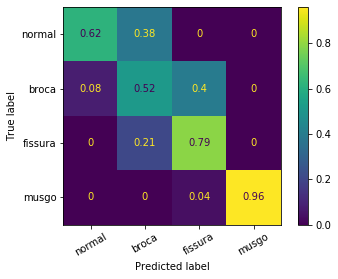

Rodada 1	-	Seed 4272
              precision    recall  f1-score   support

      normal       0.76      0.67      0.71        24
       broca       0.39      0.61      0.47        23
     fissura       0.75      0.54      0.63        28
       musgo       0.94      0.88      0.91        33

    accuracy                           0.69       108
   macro avg       0.71      0.67      0.68       108
weighted avg       0.73      0.69      0.70       108



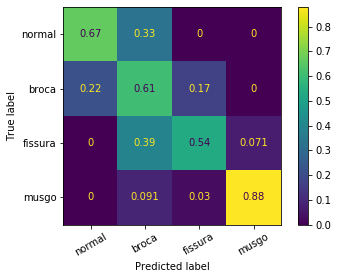

Rodada 2	-	Seed 2145
              precision    recall  f1-score   support

      normal       0.79      0.93      0.86        29
       broca       0.67      0.13      0.22        31
     fissura       0.48      0.92      0.63        25
       musgo       0.95      0.83      0.88        23

    accuracy                           0.68       108
   macro avg       0.72      0.70      0.65       108
weighted avg       0.72      0.68      0.63       108



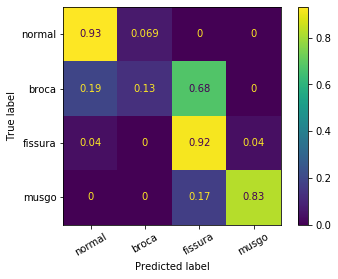

Rodada 3	-	Seed 1387
              precision    recall  f1-score   support

      normal       0.58      0.78      0.67        18
       broca       0.64      0.31      0.42        29
     fissura       0.57      0.85      0.69        27
       musgo       0.90      0.79      0.84        34

    accuracy                           0.68       108
   macro avg       0.68      0.68      0.65       108
weighted avg       0.70      0.68      0.66       108



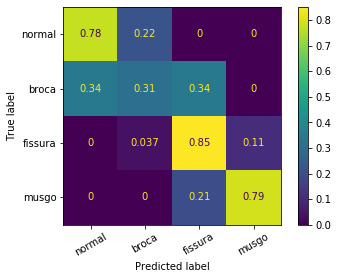

Rodada 4	-	Seed 5782
              precision    recall  f1-score   support

      normal       0.88      0.64      0.74        33
       broca       0.56      0.62      0.59        24
     fissura       0.75      1.00      0.86        27
       musgo       1.00      0.88      0.93        24

    accuracy                           0.78       108
   macro avg       0.80      0.78      0.78       108
weighted avg       0.80      0.78      0.78       108



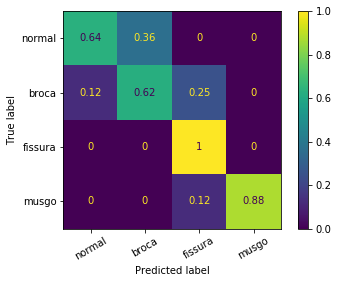

Rodada 5	-	Seed 6058
              precision    recall  f1-score   support

      normal       0.86      0.89      0.87        27
       broca       0.62      0.28      0.38        29
     fissura       0.52      0.85      0.65        27
       musgo       0.91      0.84      0.87        25

    accuracy                           0.70       108
   macro avg       0.73      0.71      0.69       108
weighted avg       0.72      0.70      0.68       108



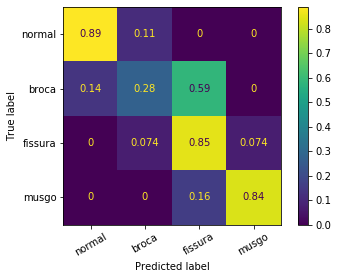

Rodada 6	-	Seed 170
              precision    recall  f1-score   support

      normal       0.70      0.68      0.69        28
       broca       0.58      0.22      0.32        32
     fissura       0.47      0.93      0.62        27
       musgo       0.94      0.71      0.81        21

    accuracy                           0.61       108
   macro avg       0.67      0.63      0.61       108
weighted avg       0.66      0.61      0.59       108



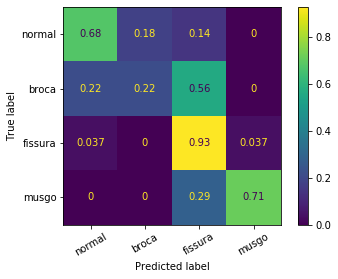

Rodada 7	-	Seed 3668
              precision    recall  f1-score   support

      normal       0.71      0.88      0.79        17
       broca       0.76      0.46      0.58        28
     fissura       0.74      0.85      0.79        33
       musgo       0.91      0.97      0.94        30

    accuracy                           0.79       108
   macro avg       0.78      0.79      0.77       108
weighted avg       0.79      0.79      0.77       108



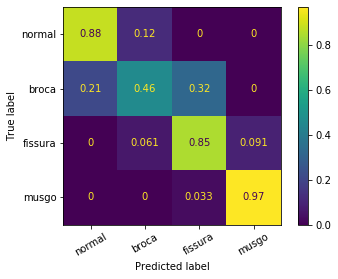

Rodada 8	-	Seed 4447
              precision    recall  f1-score   support

      normal       0.79      0.82      0.81        28
       broca       0.57      0.29      0.38        28
     fissura       0.60      0.86      0.71        28
       musgo       0.88      0.92      0.90        24

    accuracy                           0.71       108
   macro avg       0.71      0.72      0.70       108
weighted avg       0.70      0.71      0.69       108



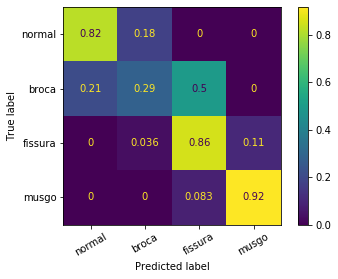

Rodada 9	-	Seed 305
              precision    recall  f1-score   support

      normal       0.96      0.65      0.77        34
       broca       0.54      0.42      0.47        33
     fissura       0.57      0.96      0.71        26
       musgo       0.93      0.93      0.93        15

    accuracy                           0.69       108
   macro avg       0.75      0.74      0.72       108
weighted avg       0.73      0.69      0.69       108



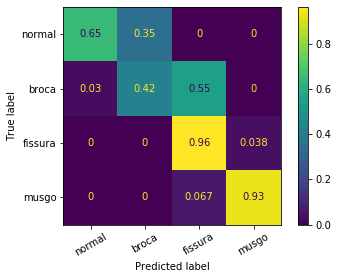

Rodada 10	-	Seed 1953
              precision    recall  f1-score   support

      normal       0.84      0.72      0.78        29
       broca       0.53      0.34      0.42        29
     fissura       0.53      0.81      0.64        26
       musgo       0.83      0.83      0.83        24

    accuracy                           0.67       108
   macro avg       0.68      0.68      0.67       108
weighted avg       0.68      0.67      0.66       108



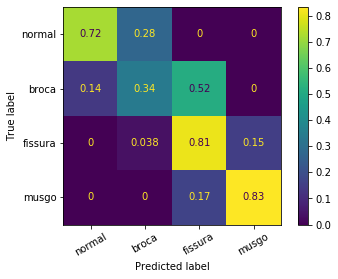

Rodada 11	-	Seed 1825
              precision    recall  f1-score   support

      normal       0.68      0.81      0.74        26
       broca       0.62      0.34      0.44        29
     fissura       0.61      0.80      0.69        25
       musgo       0.93      0.93      0.93        28

    accuracy                           0.71       108
   macro avg       0.71      0.72      0.70       108
weighted avg       0.71      0.71      0.70       108



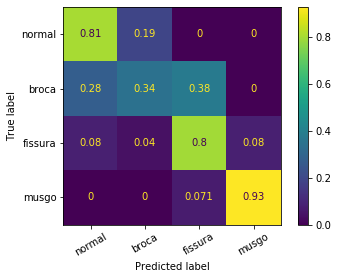

Rodada 12	-	Seed 5727
              precision    recall  f1-score   support

      normal       0.84      0.52      0.64        31
       broca       0.39      0.54      0.45        26
     fissura       0.74      0.71      0.72        35
       musgo       0.84      1.00      0.91        16

    accuracy                           0.66       108
   macro avg       0.70      0.69      0.68       108
weighted avg       0.70      0.66      0.66       108



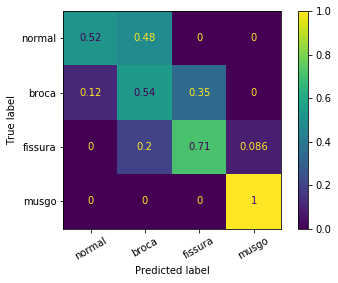

Rodada 13	-	Seed 6567
              precision    recall  f1-score   support

      normal       0.80      0.67      0.73        30
       broca       0.33      0.48      0.39        21
     fissura       0.71      0.71      0.71        28
       musgo       1.00      0.86      0.93        29

    accuracy                           0.69       108
   macro avg       0.71      0.68      0.69       108
weighted avg       0.74      0.69      0.71       108



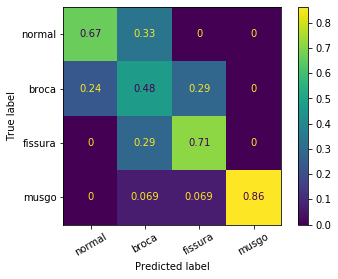

Rodada 14	-	Seed 4664
              precision    recall  f1-score   support

      normal       0.63      1.00      0.78        19
       broca       0.67      0.20      0.31        30
     fissura       0.65      0.88      0.75        34
       musgo       1.00      0.92      0.96        25

    accuracy                           0.72       108
   macro avg       0.74      0.75      0.70       108
weighted avg       0.73      0.72      0.68       108



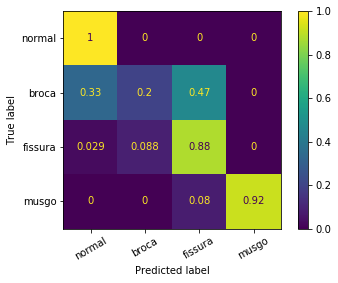

Rodada 15	-	Seed 7027
              precision    recall  f1-score   support

      normal       0.64      0.73      0.68        22
       broca       0.36      0.42      0.38        24
     fissura       0.67      0.62      0.64        29
       musgo       0.96      0.82      0.89        33

    accuracy                           0.66       108
   macro avg       0.66      0.65      0.65       108
weighted avg       0.68      0.66      0.67       108



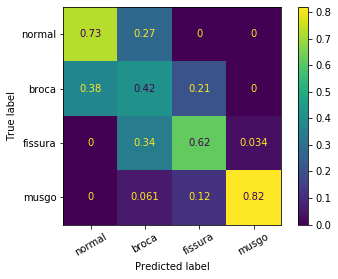

Rodada 16	-	Seed 7469
              precision    recall  f1-score   support

      normal       0.76      0.73      0.74        22
       broca       0.62      0.42      0.50        24
     fissura       0.60      0.89      0.71        28
       musgo       0.93      0.79      0.86        34

    accuracy                           0.72       108
   macro avg       0.73      0.71      0.70       108
weighted avg       0.74      0.72      0.72       108



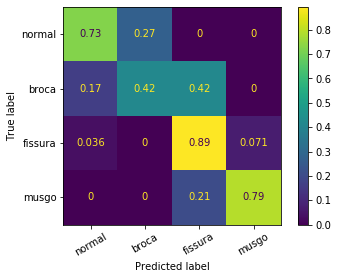

Rodada 17	-	Seed 6770
              precision    recall  f1-score   support

      normal       0.67      0.56      0.61        25
       broca       0.52      0.58      0.55        26
     fissura       0.71      0.83      0.77        30
       musgo       0.96      0.81      0.88        27

    accuracy                           0.70       108
   macro avg       0.71      0.70      0.70       108
weighted avg       0.72      0.70      0.71       108



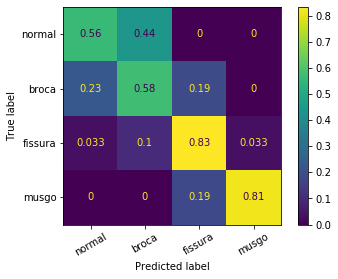

Rodada 18	-	Seed 4566
              precision    recall  f1-score   support

      normal       0.67      0.71      0.69        31
       broca       0.50      0.33      0.40        30
     fissura       0.69      0.89      0.77        27
       musgo       0.90      0.90      0.90        20

    accuracy                           0.69       108
   macro avg       0.69      0.71      0.69       108
weighted avg       0.67      0.69      0.67       108



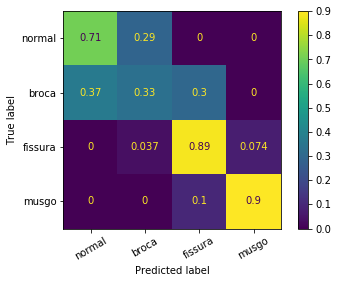

Rodada 19	-	Seed 122
              precision    recall  f1-score   support

      normal       0.76      0.81      0.79        27
       broca       0.56      0.38      0.45        26
     fissura       0.63      0.81      0.71        27
       musgo       0.88      0.82      0.85        28

    accuracy                           0.71       108
   macro avg       0.71      0.71      0.70       108
weighted avg       0.71      0.71      0.70       108



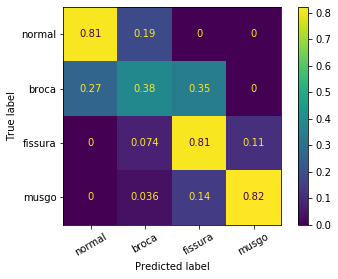

Rodada 20	-	Seed 4773
              precision    recall  f1-score   support

      normal       0.57      0.74      0.64        23
       broca       0.38      0.41      0.39        27
     fissura       0.65      0.55      0.60        31
       musgo       0.91      0.78      0.84        27

    accuracy                           0.61       108
   macro avg       0.63      0.62      0.62       108
weighted avg       0.63      0.61      0.62       108



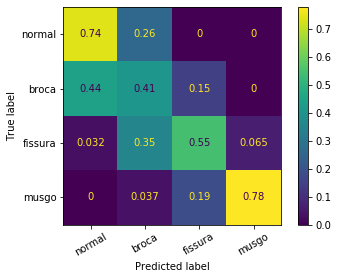

Rodada 21	-	Seed 5986
              precision    recall  f1-score   support

      normal       0.78      0.70      0.74        30
       broca       0.47      0.59      0.52        27
     fissura       0.67      0.59      0.63        27
       musgo       0.96      0.92      0.94        24

    accuracy                           0.69       108
   macro avg       0.72      0.70      0.71       108
weighted avg       0.71      0.69      0.70       108



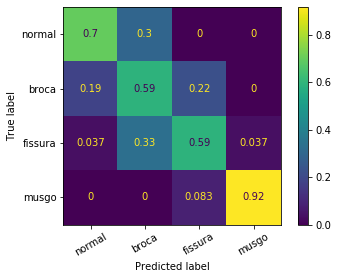

Rodada 22	-	Seed 2661
              precision    recall  f1-score   support

      normal       1.00      0.46      0.63        35
       broca       0.29      0.45      0.35        20
     fissura       0.58      0.81      0.68        27
       musgo       0.91      0.81      0.86        26

    accuracy                           0.63       108
   macro avg       0.70      0.63      0.63       108
weighted avg       0.74      0.63      0.64       108



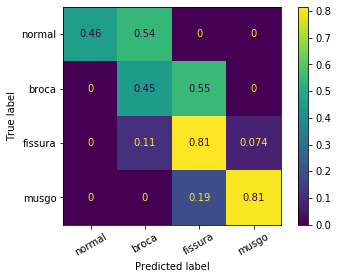

Rodada 23	-	Seed 6463
              precision    recall  f1-score   support

      normal       0.56      0.78      0.65        23
       broca       0.43      0.20      0.27        30
     fissura       0.57      0.84      0.68        25
       musgo       1.00      0.83      0.91        30

    accuracy                           0.65       108
   macro avg       0.64      0.66      0.63       108
weighted avg       0.65      0.65      0.62       108



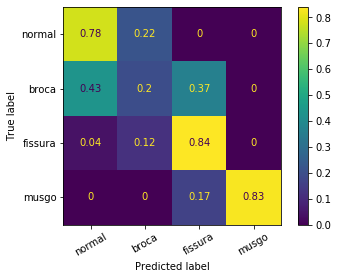

Rodada 24	-	Seed 1173
              precision    recall  f1-score   support

      normal       0.80      0.80      0.80        25
       broca       0.64      0.36      0.46        25
     fissura       0.53      0.90      0.67        20
       musgo       0.94      0.87      0.90        38

    accuracy                           0.74       108
   macro avg       0.73      0.73      0.71       108
weighted avg       0.76      0.74      0.73       108



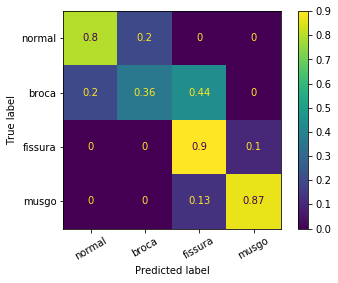

Rodada 25	-	Seed 893
              precision    recall  f1-score   support

      normal       0.81      0.63      0.71        27
       broca       0.54      0.58      0.56        24
     fissura       0.76      0.86      0.81        29
       musgo       0.93      0.93      0.93        28

    accuracy                           0.76       108
   macro avg       0.76      0.75      0.75       108
weighted avg       0.77      0.76      0.76       108



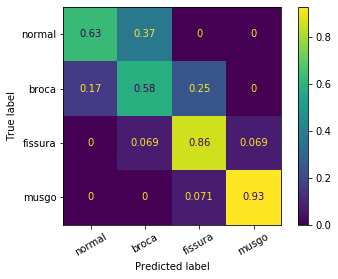

Rodada 26	-	Seed 6859
              precision    recall  f1-score   support

      normal       0.80      0.46      0.59        26
       broca       0.41      0.46      0.44        26
     fissura       0.57      0.83      0.68        29
       musgo       0.91      0.74      0.82        27

    accuracy                           0.63       108
   macro avg       0.67      0.62      0.63       108
weighted avg       0.67      0.63      0.63       108



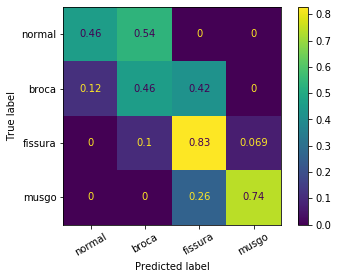

Rodada 27	-	Seed 6926
              precision    recall  f1-score   support

      normal       0.86      0.76      0.81        25
       broca       0.45      0.17      0.24        30
     fissura       0.44      0.96      0.60        23
       musgo       0.96      0.80      0.87        30

    accuracy                           0.65       108
   macro avg       0.68      0.67      0.63       108
weighted avg       0.69      0.65      0.63       108



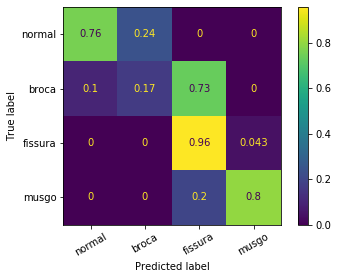

Rodada 28	-	Seed 2360
              precision    recall  f1-score   support

      normal       0.74      0.74      0.74        23
       broca       0.47      0.28      0.35        29
     fissura       0.40      0.68      0.51        25
       musgo       0.92      0.77      0.84        31

    accuracy                           0.61       108
   macro avg       0.63      0.62      0.61       108
weighted avg       0.64      0.61      0.61       108



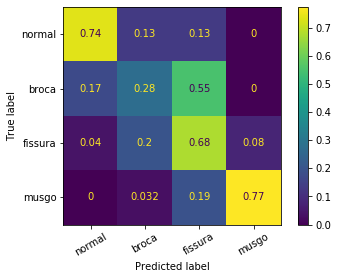

Rodada 29	-	Seed 1296
              precision    recall  f1-score   support

      normal       0.79      0.63      0.70        30
       broca       0.43      0.46      0.44        26
     fissura       0.64      0.72      0.68        29
       musgo       0.87      0.87      0.87        23

    accuracy                           0.67       108
   macro avg       0.68      0.67      0.67       108
weighted avg       0.68      0.67      0.67       108



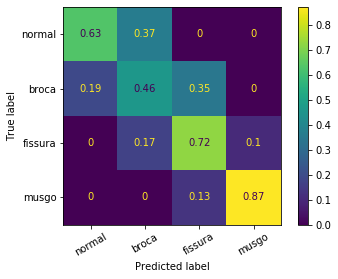

In [4]:
df = pd.read_csv('./csvs/lbp_toras.csv')
y = df.pop('target').values
X = df.values

# Gerando 30 sementes "aleatórias" dentro do intervalo [0, 8000)
seed_arr = np.random.randint(8000, size=30)

acc_e_f1_por_rodada = []
confu_matrices = []

for rodada, seed in enumerate(seed_arr):
  # separando dados
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

  clf = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  
  # Adicionando resultados à respectiva lista
  acc_e_f1_por_rodada.append(
    [accuracy_score(y_test, y_pred)]
    + list(f1_score(y_test, y_pred, average=None)))

  confu_matrices.append(
    confusion_matrix(y_test, y_pred, normalize='true'))

  print(f'Rodada {rodada}\t-\tSeed {seed}')
  print(
    classification_report(
      y_true=y_test,
      y_pred=y_pred,
      target_names=TARGET_NAMES))

  plot_confusion_matrix(
    estimator=clf,
    X=X_test,
    y_true=y_test,
    display_labels=TARGET_NAMES,
    xticks_rotation=30,
    normalize='true')
  
  plt.show()

## Métricas do experimento

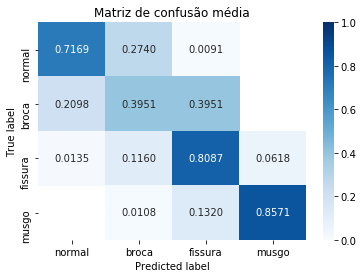

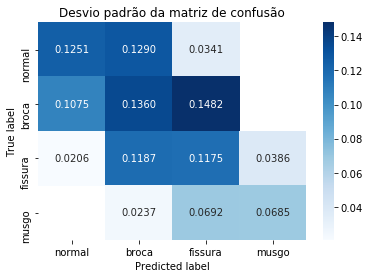

In [5]:
confusion_matrix_mean = np.mean(confu_matrices, axis=0)
confusion_matrix_std = np.std(confu_matrices, axis=0)

sns.heatmap(
    data=confusion_matrix_mean,
    cmap='Blues',
    vmin=0,
    vmax=1,
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_mean == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Matriz de confusão média',
        xlabel='Predicted label',
        ylabel='True label')

plt.show()

sns.heatmap(
    data=confusion_matrix_std,
    cmap='Blues',
    annot=True,
    fmt='.4f',
    mask=confusion_matrix_std == 0,
    xticklabels=TARGET_NAMES,
    yticklabels=TARGET_NAMES
    ).set(
        title='Desvio padrão da matriz de confusão',
        xlabel='Predicted label',
        ylabel='True label')

None

        Acurácia  f1-normal   f1-broca  f1-fissura   f1-musgo
count  30.000000  30.000000  30.000000   30.000000  30.000000
mean    0.687346   0.726942   0.421239    0.688369   0.890324
std     0.046436   0.070835   0.093419    0.071218   0.042773
min     0.611111   0.585366   0.216216    0.507463   0.810811
25%     0.657407   0.682513   0.380952    0.637987   0.857143
50%     0.689815   0.735768   0.427484    0.681993   0.891603
75%     0.712963   0.777211   0.474114    0.722050   0.927910
max     0.787037   0.872727   0.588235    0.857143   0.979592


Acurácia,f1-normal,f1-broca,f1-fissura,f1-musgo
0.722222,0.734694,0.472727,0.730159,0.979592
0.685185,0.711111,0.474576,0.625000,0.906250
0.675926,0.857143,0.216216,0.630137,0.883721
0.675926,0.666667,0.418605,0.686567,0.843750
0.777778,0.736842,0.588235,0.857143,0.933333
0.703704,0.872727,0.380952,0.647887,0.875000
0.611111,0.690909,0.318182,0.625000,0.810811
0.787037,0.789474,0.577778,0.788732,0.935484
0.712963,0.807018,0.380952,0.705882,0.897959
0.694444,0.771930,0.474576,0.714286,0.933333


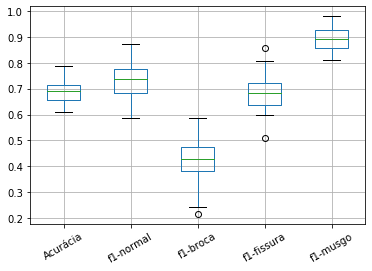

In [6]:
acc_df = pd.DataFrame(
  data=acc_e_f1_por_rodada,
  columns=['Acurácia'] + [f'f1-{name}' for name in TARGET_NAMES])

print(acc_df.describe())

acc_df.boxplot(rot=30)

acc_df.style.hide_index().background_gradient(cmap='Blues')